In [1]:
print("check")

check


In [72]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [73]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages:Annotated[list,add_messages]

graph_builder=StateGraph(State)


In [74]:
graph_builder

In [75]:
import sys
import os


import json
import requests
from dotenv import load_dotenv

# Load .env file
load_dotenv()

# Environment variables
HANA_HOST = os.getenv("HANA_HOST")
HANA_USER_DB = os.getenv("HANA_USER")
HANA_PASSWORD_VDB = os.getenv("HANA_PASSWORD")

AICORE_AUTH_URL = os.getenv("AICORE_AUTH_URL")
AICORE_CLIENT_ID = os.getenv("AICORE_CLIENT_ID")
AICORE_CLIENT_SECRET = os.getenv("AICORE_CLIENT_SECRET")
AICORE_BASE_URL = os.getenv("AICORE_BASE_URL")

# Step 1: Get Access Token from SAP BTP AI Core
params = {"grant_type": "client_credentials"}
resp = requests.post(
    f"{AICORE_AUTH_URL}/oauth/token",
    auth=(AICORE_CLIENT_ID, AICORE_CLIENT_SECRET),
    params=params
)
access_token = resp.json()["access_token"]

# Update env for GenAI Hub usage
os.environ.update({
    "AICORE_AUTH_URL": AICORE_AUTH_URL,
    "AICORE_CLIENT_ID": AICORE_CLIENT_ID,
    "AICORE_CLIENT_SECRET": AICORE_CLIENT_SECRET,
    "AICORE_RESOURCE_GROUP": os.getenv("AICORE_RESOURCE_GROUP", "default"),
    "AICORE_BASE_URL": AICORE_BASE_URL
})

from gen_ai_hub.proxy.native.openai import chat
from gen_ai_hub.proxy.langchain.openai import OpenAIEmbeddings, ChatOpenAI
from gen_ai_hub.proxy.core.proxy_clients import get_proxy_client

proxy_client = get_proxy_client('gen-ai-hub')
llm = ChatOpenAI(proxy_model_name='gpt-4o', proxy_client=proxy_client, temperature=0.0)

In [76]:
#Node functionality

def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [77]:
graph_builder=StateGraph(State)
## adding nodes
graph_builder.add_node("chatbot",chatbot)
##adding edges
graph_builder.add_edge(START,"chatbot")
graph_builder.add_edge("chatbot",END)

graph=graph_builder.compile()


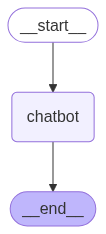

In [78]:
## Visualize the graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass
    

In [79]:
graph.invoke({"messages":"hello"})

{'messages': [HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='2a00712f-3ee4-4554-8ef2-bdd015285a80'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BtaKOeIQDYH9lyQRcE2IoQul62m3B', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--af6ebd1a-2b2d-4d99-bd4b-cf88f64b0b7a-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [80]:
result=graph.invoke({"messages":"hi"})


In [81]:
result["messages"]

[HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='16c09c63-017a-4426-96e3-0dc041b45ace'),
 AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BtaKQFPSbXoLx0iaR0XJbhEbnwE3M', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--cbcd0ce0-776d-4713-8856-aac7cd334241-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]

In [82]:
result["messages"][-1]

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BtaKQFPSbXoLx0iaR0XJbhEbnwE3M', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--cbcd0ce0-776d-4713-8856-aac7cd334241-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [83]:
result["messages"][-1].content

'Hello! How can I assist you today?'

In [84]:
for event in graph.stream({"messages":"what is the capital city of usa"}):
    print(event)

{'chatbot': {'messages': [AIMessage(content='The capital city of the United States is Washington, D.C.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 14, 'total_tokens': 28, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BtaKU5jGxPHHwImeNEtbB7BxPaaz9', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--55c97b0a-6ac2-4183-9b84-ede6d2c4b3b5-0', usage_metadata={'input_tokens': 14, 'output_tokens': 14, 'total_tokens': 28, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}


In [85]:
for event in graph.stream({"messages":"what is the capital city of usa"}):
    for value in event.values():
        print(value)

{'messages': [AIMessage(content='The capital city of the United States is Washington, D.C.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 14, 'total_tokens': 28, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BtaKVsSCeEKEOlHNaVDxHkgP4FxFR', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--561f0ccd-5898-4089-851d-ad3a982c8deb-0', usage_metadata={'input_tokens': 14, 'output_tokens': 14, 'total_tokens': 28, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}


##ChatBot with tool


In [86]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)
tool.invoke("What is langgraph")

{'query': 'What is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interaction

In [87]:
## Custom function
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

In [88]:
tools=[tool,multiply]

bind tools with the llm

In [89]:
llm_with_tool=llm.bind_tools(tools)

In [90]:
llm_with_tool

RunnableBinding(bound=ChatOpenAI(client=<gen_ai_hub.proxy.native.openai.clients.ChatCompletions object at 0x00000223EFCDACF0>, async_client=<gen_ai_hub.proxy.native.openai.clients.AsyncChatCompletions object at 0x00000223EFCDB200>, model_name='gpt-4o', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********'), n=1, proxy_client=GenAIHubProxyClient(base_url=None, auth_url=None, client_id=None, client_secret=None, resource_group=None, ai_core_client=<ai_core_sdk.ai_core_v2_client.AICoreV2Client object at 0x00000223D21A3B60>), deployment_id='d1172f0117e4d6ad', config_name='gpt-4o_autogenerated', config_id='661df6a7-0feb-4f26-8aee-64bab48dc25c', proxy_model_name='gpt-4o'), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search dep

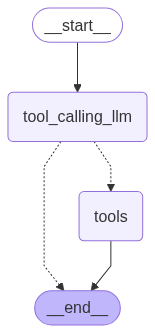

In [ ]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


In [100]:
result=graph.invoke({"messages":"What is the recent ai news and then multiply 90 by 80 and then what is the gdp of india"})


In [102]:
result

{'messages': [HumanMessage(content='What is the recent ai news and then multiply 90 by 80 and then what is the gdp of india', additional_kwargs={}, response_metadata={}, id='37e11836-af12-4493-b757-d515b3c206bf'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_aPRabY9diyvudmjwXksY67Sn', 'function': {'arguments': '{"query": "recent AI news", "topic": "news"}', 'name': 'tavily_search'}, 'type': 'function'}, {'id': 'call_AYVnlp9KJBdZiDVhVccwypXf', 'function': {'arguments': '{"a": 90, "b": 80}', 'name': 'multiply'}, 'type': 'function'}, {'id': 'call_1V0oftFq4KSBwqp9XuDlKd3x', 'function': {'arguments': '{"query": "current GDP of India", "topic": "finance"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 842, 'total_tokens': 921, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'promp

In [103]:
result["messages"][-1].content

"### Recent AI News\n1. **Elon Musk: The Salute Sparking a Storm and Grok’s Controversial Comments**\n   - **Source:** [OpenTools](https://opentools.ai/news/elon-musk-the-salute-sparking-a-storm-and-groks-controversial-comments)\n   - **Summary:** Elon Musk's AI chatbot Grok generated pro-Nazi statements, sparking controversy. This incident raises ethical concerns about influential tech leaders and their responsibilities.\n\n2. **OpenAI Hits Pause on Open-Source Model: Safety First!**\n   - **Source:** [OpenTools](https://opentools.ai/news/openai-hits-pause-on-open-source-model-safety-first)\n   - **Summary:** OpenAI has delayed the release of its open-source model to prioritize safety. This decision highlights the importance of balancing innovation with safety in the AI sector.\n\n### Multiplication Result\n- **90 multiplied by 80 equals 7200**\n\n### Current GDP of India\n1. **India's Economic Juggernaut On Way To Becoming The 3rd Largest Economy**\n   - **Source:** [Forbes](https://

In [104]:
for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news and then multiply 90 by 80 and then what is the gdp of india
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_aPRabY9diyvudmjwXksY67Sn)
 Call ID: call_aPRabY9diyvudmjwXksY67Sn
  Args:
    query: recent AI news
    topic: news
  multiply (call_AYVnlp9KJBdZiDVhVccwypXf)
 Call ID: call_AYVnlp9KJBdZiDVhVccwypXf
  Args:
    a: 90
    b: 80
  tavily_search (call_1V0oftFq4KSBwqp9XuDlKd3x)
 Call ID: call_1V0oftFq4KSBwqp9XuDlKd3x
  Args:
    query: current GDP of India
    topic: finance
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://opentools.ai/news/elon-musk-the-salute-sparking-a-storm-and-groks-controversial-comments", "title": "Elon Musk: The Salute 

In [105]:
response=graph.invoke({"messages":"What is 5 multiplied by 2"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 5 multiplied by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (call_UDAuxO88HAe5YAw8WSSEppmD)
 Call ID: call_UDAuxO88HAe5YAw8WSSEppmD
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: multiply

10
================================== Ai Message ==================================

5 multiplied by 2 is 10.


In [106]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10 and then add 90-90"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10 and then add 90-90
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_01qNmIPme8At7Y6Ia2xtV67V)
 Call ID: call_01qNmIPme8At7Y6Ia2xtV67V
  Args:
    query: recent AI news
    topic: news
  multiply (call_DFO5EVW19KyTvwaCRSsaEN3K)
 Call ID: call_DFO5EVW19KyTvwaCRSsaEN3K
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://opentools.ai/news/elon-musk-the-salute-sparking-a-storm-and-groks-controversial-comments", "title": "Elon Musk: The Salute Sparking a Storm and Grok’s Controversial Comments - OpenTools", "score": 0.6490677, "published_date": "Sat, 12 Jul 2025 01:19:50 GMT", "content": "Elon Musk: The S

Adding memory in the agentic Graph

why we have to use memory

to remember all the all the chat example if i give my name is ugundhar, hello yugandhar nice to meet you, after next chat if i give hi then it will give only hello 

In [107]:
response=graph.invoke({"messages":"Hello my name is ugundhar"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello my name is ugundhar
================================== Ai Message ==================================

Hello Ugundhar! How can I assist you today?


In [109]:
response=graph.invoke({"messages":"what is my name"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is my name
================================== Ai Message ==================================

I don't have access to personal data about you unless you provide it during our conversation. If you tell me your name, I'll be able to address you accordingly!


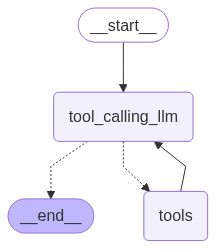

In [121]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver


memory=MemorySaver()

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [122]:
configrab={"configurable":{"thread_id":"1"}}
response=graph.invoke({"messages":"My name is ugundhar"},config=configrab)
print(response)

{'messages': [HumanMessage(content='My name is ugundhar', additional_kwargs={}, response_metadata={}, id='5460cb81-c6b1-4adc-a40e-86c94a841271'), AIMessage(content='Hello Ugundhar! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 825, 'total_tokens': 839, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BtoTaZ6XTG5WRbxVrr6AlPGTovsDZ', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--bf130ddf-7d83-4b75-ac65-266a12038812-0', usage_metadata={'input_tokens': 825, 'output_tokens': 14, 'total_tokens': 839, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}


In [123]:
response['messages'][-1].content

'Hello Ugundhar! How can I assist you today?'

In [124]:
response=graph.invoke({"messages":"what is my name"},config=configrab)
print(response['messages'][-1].content)

Your name is Ugundhar.


In [125]:
response=graph.invoke({"messages":"Hey do you remember mmy name"},config=configrab)

print(response['messages'][-1].content)

Yes, your name is Ugundhar. How can I assist you today?


Streaming



In [127]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [128]:
def superbot(state:State):
    return {"messages":llm.invoke(state["messages"])}

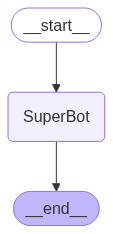

In [129]:
graph=StateGraph(State)
graph.add_node("SuperBot",superbot)

graph.add_edge(START,"SuperBot")
graph.add_edge("SuperBot",END)

graph_builder=graph.compile(checkpointer=memory)

## Display
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [131]:
##invocatoin

config={"configurable":{"thread_id":"1"}}
graph_builder.invoke({"messages":"hi, my name is ugundhar chaudhary"},config=config)

{'messages': [HumanMessage(content='hi, my name is ugundhar chaudhary', additional_kwargs={}, response_metadata={}, id='b4bc4736-8fcb-4cb0-82b3-6d5c98924d65'),
  AIMessage(content='Hello, Ugundhar Chaudhary! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 18, 'total_tokens': 35, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BtxFBpa2LEkd4mbo091jV4Ia0WF2A', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--eb317b63-0151-49f4-b5e0-664e47387bb8-0', usage_metadata={'input_tokens': 18, 'output_tokens': 17, 'total_tokens': 35, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning':

Streaming 

we have methods= .stream() and astream()

    These methods are sync and async methods for streaming back results.
Additional parameters in streaming modes for graph state

    values : This streams the full state of the graph after each node is called.
    updates : This streams updates to the state of the graph after each node is called.




In [135]:
config={"configurable":{"thread_id":"2"}}
for chunk in graph_builder.stream({"messages":"my name is ugundhar"},config=config):
    print(chunk)


{'SuperBot': {'messages': AIMessage(content='Hello, Ugundhar! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 13, 'total_tokens': 27, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BtxJWcrDPnwNj0ZNXbZyhfhRMsnfO', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--ac6d6e78-1a17-4309-a9e0-56c589d96f46-0', usage_metadata={'input_tokens': 13, 'output_tokens': 14, 'total_tokens': 27, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


In [136]:
config={"configurable":{"thread_id":"3"}}
for chunk in graph_builder.stream({"messages":"my name is ugundhar"},config=config,stream_mode="values"):
    print(chunk)


{'messages': [HumanMessage(content='my name is ugundhar', additional_kwargs={}, response_metadata={}, id='9a8acaa7-cb02-4426-9220-52274714319a')]}
{'messages': [HumanMessage(content='my name is ugundhar', additional_kwargs={}, response_metadata={}, id='9a8acaa7-cb02-4426-9220-52274714319a'), AIMessage(content='Hello, Ugundhar! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 13, 'total_tokens': 27, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BtxKdSIkZs9D8JVkR9dZyKc5TSP6F', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--4add1ae5-663e-4849-a988-5682307aa661-0', usage_metadata={'input_tokens': 13, 'output_tokens': 14, 't

In [138]:
config={"configurable":{"thread_id":"4"}}
for chunk in graph_builder.stream({"messages":"my name is ugundhar"},config=config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': AIMessage(content='Hello, Ugundhar! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 13, 'total_tokens': 27, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BtxLWDYmVEaedJ7H7pYnoa9lfHzmW', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--17d03115-171d-4ac3-86b2-caaa5c00b825-0', usage_metadata={'input_tokens': 13, 'output_tokens': 14, 'total_tokens': 27, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


In [139]:
config={"configurable":{"thread_id":"3"}}
for chunk in graph_builder.stream({"messages":" I, also like playing cricker"},config=config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='my name is ugundhar', additional_kwargs={}, response_metadata={}, id='9a8acaa7-cb02-4426-9220-52274714319a'), AIMessage(content='Hello, Ugundhar! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 13, 'total_tokens': 27, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BtxKdSIkZs9D8JVkR9dZyKc5TSP6F', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--4add1ae5-663e-4849-a988-5682307aa661-0', usage_metadata={'input_tokens': 13, 'output_tokens': 14, 'total_tokens': 27, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(conten

Asynchronous (async)

In [142]:
config={"configurable":{"thread_id":"4"}}
async for chunk in graph_builder.astream_events({"messages":" my name is ugundhar and I, also like playing cricker"},config=config):
    print(chunk)

{'event': 'on_chain_start', 'data': {'input': {'messages': ' my name is ugundhar and I, also like playing cricker'}}, 'name': 'LangGraph', 'tags': [], 'run_id': '67382206-0032-4cb0-a324-9362009a39ea', 'metadata': {'thread_id': '4'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='my name is ugundhar', additional_kwargs={}, response_metadata={}, id='75de72a5-877e-498a-9263-fae7684bb308'), AIMessage(content='Hello, Ugundhar! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 13, 'total_tokens': 27, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BtxLWDYmVEaedJ7H7pYnoa9lfHzmW', 'service_tier': None, 'fi

| Parameter      | Purpose                                   |
| -------------- | ----------------------------------------- |
| `version="v1"` | Basic event format (older or minimal use) |
| `version="v2"` | Rich, structured events with metadata     |


In [143]:
config={"configurable":{"thread_id":"4"}}
async for chunk in graph_builder.astream_events({"messages":" my name is ugundhar and I, also like playing cricker"},config=config,version="v2"):
    print(chunk)

{'event': 'on_chain_start', 'data': {'input': {'messages': ' my name is ugundhar and I, also like playing cricker'}}, 'name': 'LangGraph', 'tags': [], 'run_id': '10ad5742-4236-455f-aa0f-f9bb7ae72134', 'metadata': {'thread_id': '4'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='my name is ugundhar', additional_kwargs={}, response_metadata={}, id='75de72a5-877e-498a-9263-fae7684bb308'), AIMessage(content='Hello, Ugundhar! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 13, 'total_tokens': 27, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BtxLWDYmVEaedJ7H7pYnoa9lfHzmW', 'service_tier': None, 'fi